# Fuel Consumption


The dataset we are going to work with contains transactions about a company that manages 82 gas stations located in Italy for the years 2018 and 2019.

**It's crucial for the sales department to quantify how much fuel needs to be reloaded into a single gas station.**

Why? 

Let's assume for simplicity that the company capital is $1 million and number of the store is 4.  
                
               
The first idea is to divide $1 million by four and reload each tank for that amount of fuel. Assuming that the cost of one liter is 0.669 we can summarize our problem as follow:

                  
|   | store 1 |  store 2 | store 3 | store 4 |
| --- | --- | --- | --- | --- |     
| re-loading cost ($) | 250K | 250K | 250K | 250K |
| new liters availability (L) | 374K | 374K | 374K | 374K |




_savings($): 0_
                  

What's wrong with this approach? 

Imagine an hot italian summer day: everyone is moving from city to the sea and, since store 1 and 2 are located close to the sea, they ruin out its fuel faster than the ones located in non-sea city.



**What if we know beforehand how much fuel will be consumed in each store?**

 
We can base the reloading cost on the prediction. 

                  
|   | store 1 |  store 2 | store 3 | store 4 |
| --- | --- | --- | --- | --- |
| re-loading cost ($) | 167K | 134K | 67K | 67K |
| prediction (L) | 300K | 250K | 100K | 100K |




_savings ($): 489000_



**With this approach we are re-loading the tank of the exactly quantity needed by saving capital that could be spent on others stores.**


In a real scenario there are multiple factors that might affects the fuel consuption, in this projects we are going to explore them in order to find a Regressor that can handle this problem. 

## Datasets Overview

We have two dataset representing for each store the transactions recorded beetween 2018 and 2019.

The attributes of the datasets are rather self explanatory. 

* store_id
* date 
* liters_dispesed
* city
* year 
* day
* month
* paid 
* average_temperatures
* maximum_temperature
* minimum_temperature
* average_umidity
* maximum_umidity
* minimum_umidity
* flurry 
* medium_visibility
* rainy_day
* dew_point
* phenomena
* average_windspeed
* maximum_windspeed 
* average_sealevelpressure
* weather_condition
* number_of_inhabitants
* average_pressure


Please note: the data has been pre-aggregate on date and extended with weather condition using Pentaho Data Integration. 


We need to add info about cities locations using the following datasets: 


1. SeaCities (source: link) 
    * city 


2. GeoCoordinates (source: link) 
    * city 
    * latitude 
    * longitude


## Setup

In [78]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=400):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_figure(figure, fig_id, tight_layout=False, fig_extension="png", resolution=400):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    figure.savefig(path, format=fig_extension, dpi=resolution) 
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import pandas as pd
from sklearn import preprocessing

from sklearn.impute import SimpleImputer

#LOAD DATA
sea= pd.read_excel("SeaCity.xls")
geo= pd.read_excel("CoordinateGEO.xls")
ds19= pd.read_excel("consumption2019.xls")
ds18= pd.read_excel("consumption2018.xls")


In [79]:
#COLUMNS TRANSLATIONS (IT->ENG)

naming_mapper = { 

    'PuntoVendita':'store_id', 
    'Citta':'city',
    'Anno':'year',
    'Mese':'month',
    'Giorno':'day', 
    'LitriErogati':'liters_dispensed', 
    'Pioggia':'rainy_day', 
    'Incasso':'paid',
    'Pioggia':'rainy_day', 
    'Temperatura  media':'average_temperature', 
    'Temperatura  minima':'minimum_temperature', 
    'Temperatura  massima':'maximum_temperature', 
    'Umidità  media':'average_umidity', 
    'Umidità  minima':'minimum_umidity',
    'Umidità  massima':'maximum_umidity', 
    'Punto  di  rugiada':'dew_point', 
    'Visibilità  media':'medium_visibility',
    'Velocità  del  vento  media':'average_windspeed', 
    'Pressione  media  sul  livello  del  mare':'average_sealevelpressure', 
    'Pressione  media':'average_pressure', 
    'Condizione  Meteo':'weather_condition',
    'Velocità  massima  del  vento':'maximum_windspeed', 
    'Data':'date', 
    'Fenomeni':'phenomena', 
    'Popolazione':'number_of_inhabitants', 
    'Raffica':'flurry'
}



def translate_weather_cond(x): 
    
    weather_condition = {
        'pioggia  e  schiarite': 'rain  and  sunny  intervals', 
        'sereno': 'clear  weather', 
        'poco  nuvoloso': 'slightly  cloudy',
        'nubi  sparse':'overcast',
        'temporale  e  schiarite':'thunderstorm  and sunny intervals',
        'sole  e  caldo':'hot  sun',
        'temporale':'thunderstorm',
        'neve':'snow', 
        'neve  e  schiarite':'snow  and  sunny  intervals',
        'nebbia  al  mattino':'morining  mist',
        'pioggia  mista  a  neve  e  schiarite':'rain  mixed  with  snow  and  sunny  intervals',
        'coperto': 'overcast',
        'pioggia  debole': 'weak rain',
        'pioggia':'rain', 
        'nebbia':'fog', 
        'neve  debole':'weak snow',
        'pioggia  mista  a  neve':'rain mixed with snow'
    }

    return weather_condition[x]

def translate_phenomena(x): 
    phenomena= {
        
        'Pioggia':'rain',
        'Nessuno':'none',
        'Pioggia  -  Temporale':'rain  -  thunderstorm',
        'Nebbia':'fog',
        'Pioggia  -  Nebbia':'rain  -  fog',
        'Neve':'snow', 
        'Pioggia  -  Neve':'rain  -  snow',
        'Pioggia  -  Temporale  -  Nebbia':'rain  -  thunderstorm',
        'Neve  -  Nebbia':'snow  -  fog',
        'Pioggia  -  Neve  -  Temporale':'rain  -  snow  -  thunderstorm', 
        'Pioggia  -  Neve  -  Nebbia':'rain  -  snow  - fog',
        'Pioggia  -  Grandine':'rain  - hailstorm', 
        'Grandine': 'hailstorm'
        
        
    }
    return phenomena[x]



#Load data
ds19 = ds19.rename(columns=naming_mapper)
ds18 = ds18.rename(columns=naming_mapper)
sea = sea.rename(columns={'CITTA':'city'})
geo = geo.rename(columns={'comune':'city'})


## Merge the data

We have to make sure that stores belongs to the same years.

In [80]:
stores_18=ds18.store_id.unique()
stores_19=ds19.store_id.unique()
storesToRemove = np.setdiff1d(np.union1d(stores_18, stores_19), np.intersect1d(stores_18,stores_19))
storesToRemove

array([  7,  24,  30,  44,  45,  46,  54,  67,  68,  73,  84,  91,  92,
       112, 116, 121, 147, 172])

In [81]:
ds = pd.concat([ds18, ds19], sort=False, ignore_index=True)

toRemove = ds.loc[ds['store_id'].isin(storesToRemove)]

ds.drop(toRemove.index, inplace=True)

ds.head()

,store_id,city,date,liters_dispensed,paid,day,month,year,average_temperature,minimum_temperature,...,medium_visibility,average_windspeed,maximum_windspeed,flurry,average_sealevelpressure,average_pressure,rainy_day,phenomena,weather_condition,number_of_inhabitants
0,165,ACQUAVIVA DELLE FONTI,2018-01-05,2118.49,3036.20,5,1,2018,10,5,...,7.0,13.0,22.0,0,1011.0,-,-,Nebbia,nebbia al mattino,13464
1,165,ACQUAVIVA DELLE FONTI,2018-01-06,2723.63,3912.83,6,1,2018,11,10,...,4.0,28.0,39.0,0,1014.0,-,-,Nessuno,nubi sparse,13464
2,165,ACQUAVIVA DELLE FONTI,2018-01-07,2439.89,3511.11,7,1,2018,12,11,...,5.0,38.0,48.0,0,1020.0,-,-,Nessuno,nubi sparse,13464
3,165,ACQUAVIVA DELLE FONTI,2018-01-08,3724.92,5350.95,8,1,2018,12,10,...,6.0,43.0,54.0,0,1024.0,-,-,Nessuno,coperto,13464
4,165,ACQUAVIVA DELLE FONTI,2018-01-09,4492.08,6435.48,9,1,2018,12,12,...,4.0,45.0,52.0,0,1022.0,-,n/d,Pioggia,coperto,13464


In [82]:
#ITA->ENG
ds.weather_condition = ds.weather_condition.apply(translate_weather_cond)
ds.phenomena=ds.phenomena.apply(translate_phenomena)

# Preprocessing

In this step we are going to analyze and transform the dataset.  

In [83]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59880 entries, 0 to 62875
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   store_id                  59880 non-null  int64  
 1   city                      59880 non-null  object 
 2   date                      59880 non-null  object 
 3   liters_dispensed          59880 non-null  float64
 4   paid                      59880 non-null  float64
 5   day                       59880 non-null  int64  
 6   month                     59880 non-null  int64  
 7   year                      59880 non-null  int64  
 8   average_temperature       59880 non-null  int64  
 9   minimum_temperature       59880 non-null  int64  
 10  maximum_temperature       59880 non-null  int64  
 11  dew_point                 59880 non-null  int64  
 12  average_umidity           59880 non-null  int64  
 13  minimum_umidity           59880 non-null  int64  
 14  maximu

Let's start by adding a column representing wether a city is close to the sea or not.

In [84]:
ds['sea_city']=ds['city']

def isSeaCity(x):
    if(np.isin(x, sea.city)):
        return 1
    return 0
        

ds['sea_city']=ds['sea_city'].apply(isSeaCity)

In [85]:
ds.sea_city.value_counts()

0    44182
1    15698
Name: sea_city, dtype: int64

In [86]:
ds

,store_id,city,date,liters_dispensed,paid,day,month,year,average_temperature,minimum_temperature,...,average_windspeed,maximum_windspeed,flurry,average_sealevelpressure,average_pressure,rainy_day,phenomena,weather_condition,number_of_inhabitants,sea_city
0,165,ACQUAVIVA DELLE FONTI,2018-01-05,2118.49,3036.20,5,1,2018,10,5,...,13.0,22.0,0,1011.0,-,-,fog,morining mist,13464,0
1,165,ACQUAVIVA DELLE FONTI,2018-01-06,2723.63,3912.83,6,1,2018,11,10,...,28.0,39.0,0,1014.0,-,-,none,overcast,13464,0
2,165,ACQUAVIVA DELLE FONTI,2018-01-07,2439.89,3511.11,7,1,2018,12,11,...,38.0,48.0,0,1020.0,-,-,none,overcast,13464,0
3,165,ACQUAVIVA DELLE FONTI,2018-01-08,3724.92,5350.95,8,1,2018,12,10,...,43.0,54.0,0,1024.0,-,-,none,overcast,13464,0
4,165,ACQUAVIVA DELLE FONTI,2018-01-09,4492.08,6435.48,9,1,2018,12,12,...,45.0,52.0,0,1022.0,-,n/d,rain,overcast,13464,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62871,150,VIBO VALENTIA,2019-01-11,1159.51,1694.49,11,1,2019,6,2,...,14.0,18.0,0,1013.0,-,n/d,rain,slightly cloudy,25520,1
62872,150,VIBO VALENTIA,2019-01-12,849.81,1247.02,12,1,2019,7,-1,...,17.0,30.0,0,1014.0,-,-,none,slightly cloudy,25520,1
62873,150,VIBO VALENTIA,2019-01-13,847.42,1240.40,13,1,2019,7,-1,...,11.0,24.0,0,1013.0,-,n/d,rain,rain and sunny intervals,25520,1
62874,150,VIBO VALENTIA,2019-01-14,1131.90,1644.82,14,1,2019,9,5,...,7.0,28.0,0,1004.0,-,n/d,rain,rain and sunny intervals,25520,1


The values of weather_condition and phenomena are shown with double splaces, let's trim them all using a lamba expression.

In [87]:
ds.weather_condition.unique()

array(['morining  mist', 'overcast', 'rain  and  sunny  intervals',
       'clear  weather', 'slightly  cloudy', 'weak rain',
       'snow  and  sunny  intervals', 'thunderstorm  and sunny intervals',
       'thunderstorm', 'hot  sun', 'rain', 'snow',
       'rain  mixed  with  snow  and  sunny  intervals', 'fog',
       'rain mixed with snow', 'weak snow'], dtype=object)

In [88]:
ds.phenomena.unique()

array(['fog', 'none', 'rain', 'rain  -  thunderstorm', 'rain  -  fog',
       'snow', 'rain  -  snow  - fog', 'rain  -  snow', 'snow  -  fog',
       'rain  - hailstorm', 'rain  -  snow  -  thunderstorm', 'hailstorm'],
      dtype=object)

In [89]:
#Transform weather_condition and phenomena
ds['weather_condition']=ds['weather_condition'].apply(lambda x: x.replace('  ',' '))
ds['phenomena']=ds['phenomena'].apply(lambda x: x.replace('  ',' '))

Since paid is directly proportional to litres_dispensed, it isn't an useful feature to work with. 

However it can be intresting to get the average_priceperliter. 

Why average? 

Don't forget that the price has been pre-aggregated on date attribute! (We are assuming that the price might change in 24 hours)

In [90]:
ds["average_priceperliter"] = ds["paid"]/ds["liters_dispensed"]

Another great feature is a boolean representing working days.

In [91]:
ds["date"] = pd.to_datetime(ds["date"],format='%Y-%m-%d').dt.date

def is_business_day(date):
    return 1 if bool(len(pd.bdate_range(date, date))) else 0

ds['working_day'] = ds['date'].apply(lambda x: is_business_day(x))

If we take a look at the phenomena we can notice that most of them are pretty similar. 

In [92]:
print(ds.phenomena.unique())

['fog' 'none' 'rain' 'rain - thunderstorm' 'rain - fog' 'snow'
 'rain - snow - fog' 'rain - snow' 'snow - fog' 'rain - hailstorm'
 'rain - snow - thunderstorm' 'hailstorm']


In order to reduce the different values of phenoma we can easly apply the following function

In [93]:
def phenomena_reduction(x): 
    
    d = {
        "none": "none", 
        "rain":"rain",
        "rain - thunderstorm":"thunderstorm",
        "fog":"rain", 
        "rain - fog": "rain",
        "rain - snow":"rain", 
        "snow" : "snow", 
        "rain - thunderstorm - fog" : "thunderstorm", 
        "rain - snow - fog" : "snow",
        "snow - fog" : "snow", 
        "rain - snow - thunderstorm": "snow", 
        "rain - hailstorm" : "rain", 
        "hailstorm" : "rain"       
        
    }

    return d[x]



ds['phenomena']=ds['phenomena'].apply(phenomena_reduction)

Since weather_condition and phenomena are very similar we prefer to keep one of them. 

In [94]:
ds = ds.drop(columns=['weather_condition'])

We need to take care of NaN values that could mess up the operations beetween features in the future. 

Let's take a look on the NaN percentage for each attribute. 

In [95]:
dsNaN = ds.isna().sum() / ds.count()
dsNaN

store_id                    0.000000
city                        0.000000
date                        0.000000
liters_dispensed            0.000000
paid                        0.000000
day                         0.000000
month                       0.000000
year                        0.000000
average_temperature         0.000000
minimum_temperature         0.000000
maximum_temperature         0.000000
dew_point                   0.000000
average_umidity             0.000000
minimum_umidity             0.000000
maximum_umidity             0.000000
medium_visibility           0.001589
average_windspeed           0.031080
maximum_windspeed           0.027313
flurry                      0.000000
average_sealevelpressure    0.000050
average_pressure            0.000000
rainy_day                   0.000000
phenomena                   0.000000
number_of_inhabitants       0.000000
sea_city                    0.000000
average_priceperliter       0.000184
working_day                 0.000000
d

In general there are several solution for NaN managing. 

1. Get rid of the rows 
2. Get rid of whole feature (column) 
3. Set the values to some value (median, mean, zero, etc)

The first solutions is better than the second one if we don't have too many NaN values of one feature. This is the case of average_sealevelpressure. 

Later on, we will apply the third option by using a pipeline. 

In [96]:
print("NaN values average_sealevelpressure: ", ds['average_sealevelpressure'].isna().value_counts()[True])

NaN values average_sealevelpressure:  3


In [97]:
ds = ds.dropna(subset=['average_sealevelpressure'])

A similar strategy can be applied on average_pressure, rainy_day, flurry

In [98]:
ds.loc[:,['average_pressure','rainy_day','flurry']]

,average_pressure,rainy_day,flurry
0,-,-,0
1,-,-,0
2,-,-,0
3,-,-,0
4,-,n/d,0
...,...,...,...
62871,-,n/d,0
62872,-,-,0
62873,-,n/d,0
62874,-,n/d,0


In [99]:
print("Unique values average_pressure: ", ds.average_pressure.unique())
print("Unique values rainy_day: ", ds.rainy_day.unique())
print("Unique values flurry: ", ds.flurry.unique())

Unique values average_pressure:  ['-']
Unique values rainy_day:  ['-' 'n/d']
Unique values flurry:  [0]


Now we are sure that these attributes are not meaningful, for that reason we drop it. 

In [100]:
#Drop columns
toDrop = ['average_pressure','rainy_day','flurry']
ds=ds.drop(columns=toDrop)

In [101]:
ds

,store_id,city,date,liters_dispensed,paid,day,month,year,average_temperature,minimum_temperature,...,maximum_umidity,medium_visibility,average_windspeed,maximum_windspeed,average_sealevelpressure,phenomena,number_of_inhabitants,sea_city,average_priceperliter,working_day
0,165,ACQUAVIVA DELLE FONTI,2018-01-05,2118.49,3036.20,5,1,2018,10,5,...,100,7.0,13.0,22.0,1011.0,rain,13464,0,1.433191,1
1,165,ACQUAVIVA DELLE FONTI,2018-01-06,2723.63,3912.83,6,1,2018,11,10,...,100,4.0,28.0,39.0,1014.0,none,13464,0,1.436623,0
2,165,ACQUAVIVA DELLE FONTI,2018-01-07,2439.89,3511.11,7,1,2018,12,11,...,100,5.0,38.0,48.0,1020.0,none,13464,0,1.439044,0
3,165,ACQUAVIVA DELLE FONTI,2018-01-08,3724.92,5350.95,8,1,2018,12,10,...,100,6.0,43.0,54.0,1024.0,none,13464,0,1.436527,1
4,165,ACQUAVIVA DELLE FONTI,2018-01-09,4492.08,6435.48,9,1,2018,12,12,...,100,4.0,45.0,52.0,1022.0,rain,13464,0,1.432628,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62871,150,VIBO VALENTIA,2019-01-11,1159.51,1694.49,11,1,2019,6,2,...,100,21.0,14.0,18.0,1013.0,rain,25520,1,1.461385,1
62872,150,VIBO VALENTIA,2019-01-12,849.81,1247.02,12,1,2019,7,-1,...,92,21.0,17.0,30.0,1014.0,none,25520,1,1.467410,0
62873,150,VIBO VALENTIA,2019-01-13,847.42,1240.40,13,1,2019,7,-1,...,100,19.0,11.0,24.0,1013.0,rain,25520,1,1.463737,0
62874,150,VIBO VALENTIA,2019-01-14,1131.90,1644.82,14,1,2019,9,5,...,100,19.0,7.0,28.0,1004.0,rain,25520,1,1.453150,1


# Data Visualization

In order to show the distribution of the stores in Italy we used the dataset called geo.

The map shows that the highest number of stores are located in northern and central Italy.

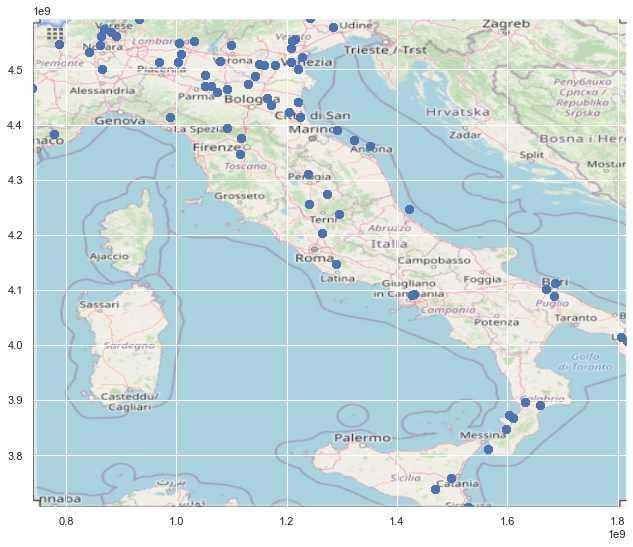

In [163]:
ds_geo = pd.merge(ds, geo, how='left', left_on='city', right_on='city')

mapGeo = plt.imread("map.jpg")
BBox = [ds_geo.lng.min(),   ds_geo.lng.max(),      
         ds_geo.lat.min(), ds_geo.lat.max()]

fig, ax = plt.subplots(figsize = (45,9))
ax.scatter(ds_geo.lng, ds_geo.lat, zorder=1, c='b', s=50)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mapGeo, zorder=0, extent = BBox, aspect= 'equal')

Temperature is a factor that could affect the fuel's purchasing. 

Let's try to relate the dataset containing the transactions and meteorological information to find out if there is any differences between the average temperatures around Italy.

For this purpose we need first to group data by calculating the mean of all the temperatures beloging to the same store and city. 

In [164]:
ds_geo = ds.groupby(['store_id','city']).agg({'average_temperature':'mean'})
ds_geo.columns=['average_temperature_mean']
ds_geo.reset_index(inplace=True)

In [165]:
ds_geo = pd.merge(ds_geo, geo, how='left', left_on='city', right_on='city')

ds_geo

,store_id,city,average_temperature_mean,lng,lat
0,5,VERCELLI,16.878641,842323431,4532398135
1,8,REVELLO,15.714286,738900592,4465466177
2,9,NOVARA,17.750725,862191588,4544588506
3,10,NOVARA,17.638968,862191588,4544588506
4,11,OLEGGIO,17.804035,863736389,4559668789
...,...,...,...,...,...
76,169,MARTELLAGO,16.664151,1215989187,4554613274
77,174,COLLEPASSO,17.618692,1816293668,4007320903
78,175,VEZZANO LIGURE,18.645161,988447876,4414135989
79,178,PESARO,16.605948,1291345991,4391014021


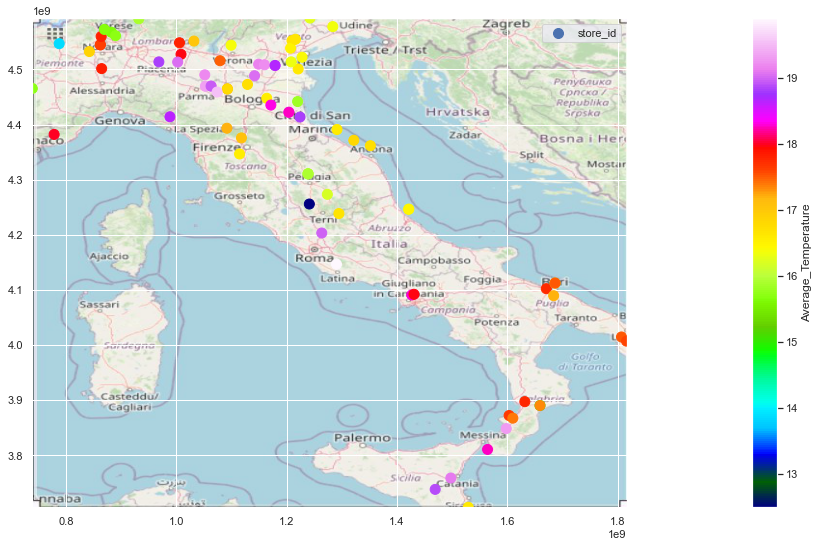

In [166]:
fig, ax = plt.subplots(figsize = (45,9))

sc= ax.scatter(ds_geo.lng, ds_geo.lat, zorder=1, s=100,c=ds_geo['average_temperature_mean'],
               label="store_id", cmap=plt.cm.gist_ncar)


ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mapGeo, zorder=0, extent = BBox, aspect= 'equal')

ax.legend()
fig.colorbar(sc, ax=ax,label='Average_Temperature')
plt.show()

The color of the dots on the map confirms the temperature differences between north and south. 

The average temperatures in northern Italy is lower than the average temperatures in southern Italy.


In [ ]:
ds_summer_months= ds.loc[(ds.month>=7) & (ds.month<=8)]

 

ds_summer_months= ds_summer_months.groupby(['store_id','city']).agg({'average_temperature':'mean','liters_dispensed':'mean'})

 

ds_summer_months.columns=['average_temperature_mean','liters_dispensed_mean']
ds_summer_months.reset_index(inplace=True)

 

ds_summer_months = pd.merge(ds_summer_months, geo, how='left', left_on='city', right_on='city')

 

ds_summer_months

Let's see what happens during summer time when people move to holiday resorts.

In [ ]:
fig, ax = plt.subplots(figsize = (45,9))
sc= ax.scatter(ds_summer_months.lng, ds_summer_months.lat, zorder=1, s=ds_summer_months["liters_dispensed_mean"]/10,
          label="liters_dispensed", c=ds_summer_months['average_temperature_mean'], cmap=plt.cm.gist_ncar)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mapGeo, zorder=0, extent = BBox, aspect= 'equal')

 

ax.legend()
fig.colorbar(sc, ax=ax,label='Average_Temperature')
save_fig("stores_distribution_3")
plt.show()

As we can see, in general, it seems that some stores close to resorts tend to increase the liters dispensed during the summer time. 

## Outliers Detection

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample.



First of all, let's print out the min value and the max value of liters_dispesed variable. 

In [103]:
ds['liters_dispensed'].min()

0.0

In [104]:
ds['liters_dispensed'].max()

24794.73

In [105]:
ds[ds['liters_dispensed']==0]

,store_id,city,date,liters_dispensed,paid,day,month,year,average_temperature,minimum_temperature,...,maximum_umidity,medium_visibility,average_windspeed,maximum_windspeed,average_sealevelpressure,phenomena,number_of_inhabitants,sea_city,average_priceperliter,working_day
782,156,AMELIA,2018-03-26,0.0,0.0,26,3,2018,11,3,...,86,22.0,15.0,24.0,1006.0,none,6788,0,NaN,1
5266,146,CASALGRANDE,2018-04-08,0.0,0.0,8,4,2018,15,8,...,87,19.0,13.0,18.0,1015.0,none,14968,0,NaN,0
9178,174,COLLEPASSO,2018-01-09,0.0,0.0,9,1,2018,15,14,...,93,20.0,21.0,30.0,1025.0,none,3340,0,NaN,1
11089,50,FIRENZE,2018-11-27,0.0,0.0,27,11,2018,10,6,...,100,20.0,9.0,17.0,1006.0,rain,924448,0,NaN,1
11945,62,FORLI',2018-11-22,0.0,0.0,22,11,2018,11,9,...,81,10.0,2.0,4.0,1020.0,none,156536,0,NaN,1
11957,62,FORLI',2018-12-06,0.0,0.0,6,12,2018,8,8,...,87,3.0,2.0,4.0,1023.0,none,156536,0,NaN,1
12545,158,GENOVA,2018-08-20,0.0,0.0,20,8,2018,29,26,...,74,21.0,10.0,17.0,1014.0,none,1006788,1,NaN,1
15079,129,MANTOVA,2018-03-21,0.0,0.0,21,3,2018,6,3,...,60,19.0,11.0,22.0,1017.0,none,29927,0,NaN,1
22799,65,REGGIO EMILIA,2018-03-14,0.0,0.0,14,3,2018,13,4,...,93,19.0,10.0,22.0,1010.0,none,252192,0,NaN,1
29140,38,VENEZIA,2018-04-26,0.0,0.0,26,4,2018,19,15,...,93,20.0,14.0,18.0,1011.0,none,472221,1,NaN,1


Could we assume that in the whole day nobody needs fuel? This is cleary an outlier, we take care of this by dropping the rows.

In [106]:
ds = ds.drop(ds[ds['liters_dispensed']==0].index)

Another great way to spot outliers is by using Iterquartile Range. 

In [107]:
from scipy import stats

Q1 = ds.quantile(0.25)
Q3 = ds.quantile(0.75)
IQR = Q3 - Q1

ds = ds[~((ds< (Q1 - 1.5 * IQR)) |(ds > (Q3 + 1.5 * IQR))).any(axis=1)]

ds= ds.dropna()

We can use z-score for outliers detection assuming a bell-shaped distribution. 

Let's plot the liters dispensed for some stores. 

In [108]:
ds.store_id.unique()

array([165, 108, 156, 159,  74,  34,  83, 122, 120,  82,  59, 136,  80,
       131, 146,  27,  28,  79, 109,  96,  66, 135, 102,  37, 105, 174,
        23,  26, 101,  62,  85, 153,  12,  81, 179,  35, 127,  21, 129,
       169,  56, 106,  63,  64,   9,  10,  11, 133,  47,  48,  99, 178,
        69,  70,  55, 145,  20,  39,  86, 143, 110,  65, 103,   8, 126,
       151,  33, 132,  36, 161,  51,  58, 113,  72,  32, 140,   5,  29,
        40, 175, 150])

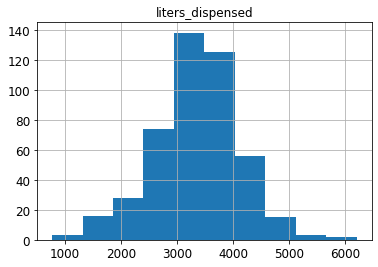

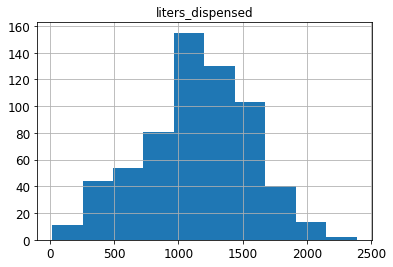

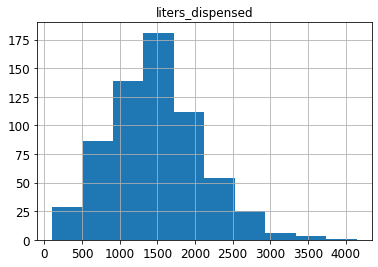

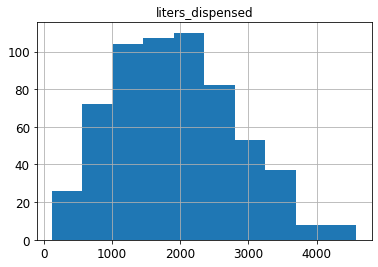

In [109]:
ds.loc[(ds.store_id==165),['liters_dispensed']].hist()
ds.loc[(ds.store_id==108),['liters_dispensed']].hist()
ds.loc[(ds.store_id==74),['liters_dispensed']].hist()
ds.loc[(ds.store_id==159),['liters_dispensed']].hist()

plt.show()

In [110]:
for store_id in ds.store_id.unique():
    
    tmp= ds.loc[ds.store_id==store_id]

    mean= np.mean(tmp.liters_dispensed)
    sd= np.std(tmp.liters_dispensed)
    
    for index in tmp.index:

        liters= tmp.loc[index,'liters_dispensed']
        
        if(not(liters >mean-2*sd and liters<mean+2*sd)):

            ds= ds.drop(index)


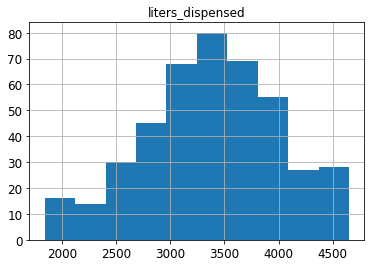

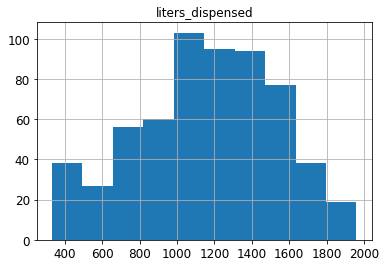

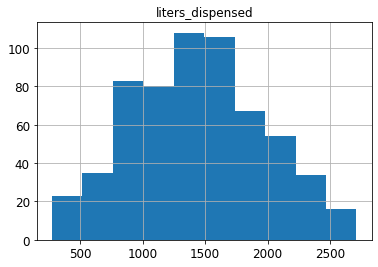

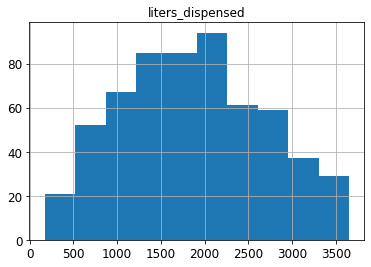

In [111]:
ds.loc[(ds.store_id==165),['liters_dispensed']].hist()
ds.loc[(ds.store_id==108),['liters_dispensed']].hist()
ds.loc[(ds.store_id==74),['liters_dispensed']].hist()
ds.loc[(ds.store_id==159),['liters_dispensed']].hist()

plt.show()

## Looking for Correlations 

In order to quantify the relationship between attributes we need to compute the standard correlation coefficient based on Pearson's coefficient.

This coefficient quantify how much two features are linearly correlated with each other.

Saving figure correlation_1


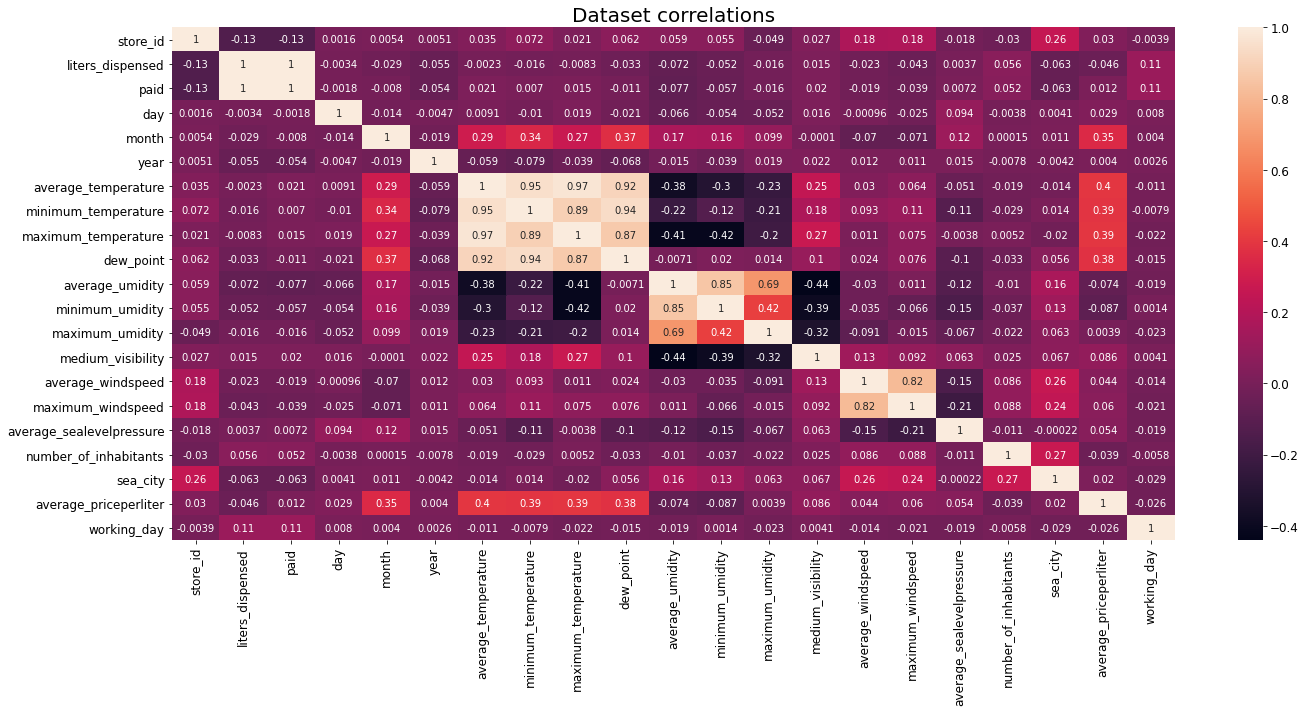

In [112]:
import seaborn as sns

fig,ax = plt.subplots(figsize=(20,10))
fig = sns.heatmap(ds.corr(), annot=True)
plt.title("Dataset correlations", size=20)
save_fig("correlation_1")
plt.show()

As we expected, a positive correlation is present mainly between similar attributes as: 
* **average_temperature** with *temperature_minimum*, *temperature_maximum*, *dew_point*
* **average_umidity** with *minimum_umidity* and *maximum_umidity*
* **average_windspeed** with *maximum_windspeed*
* **liters_dispensed** with *paid*


These type of correlations are known as multicollinearity: *a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy*. 




To show some of our intuitions about cities we have chosen to show the correlation matrix not on the entire dataset but on a particular city.

We have choosen, as an example, a city located in northern Italy and another one located in southern Italy.

Saving figure correlation_2


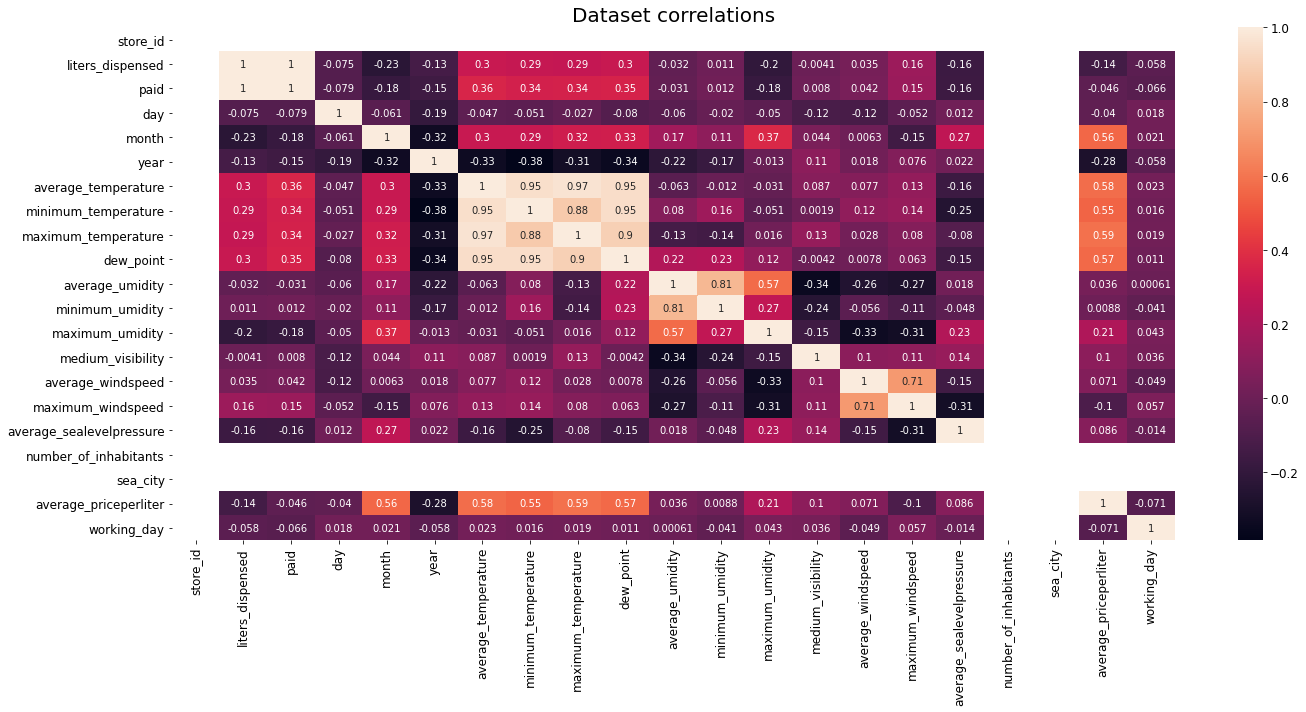

In [113]:
fig,ax = plt.subplots(figsize=(20,10))
fig = sns.heatmap(ds.loc[ds.city=='VIBO VALENTIA'].corr(), annot=True)
plt.title("Dataset correlations", size=20)
save_fig("correlation_2")
plt.show()

Saving figure correlation_3


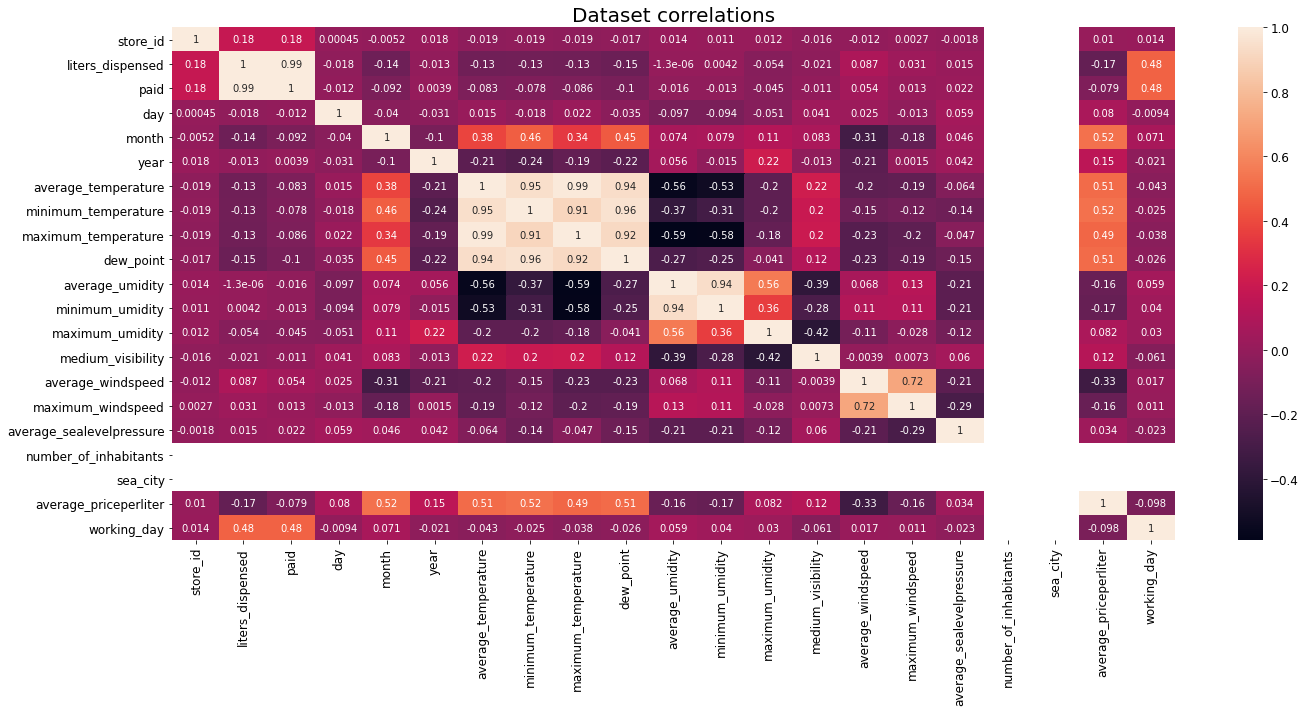

In [114]:
fig,ax = plt.subplots(figsize=(20,10))
fig = sns.heatmap(ds.loc[ds.city=='ROVIGO'].corr(), annot=True)
plt.title("Dataset correlations", size=20)
save_fig("correlation_3")
plt.show()

These two correlation matrices are very different.


*The cities of southern Italy are characterized by a mild climate and they are generally located close to the sea while the ones of northern Italy, generally not bathed by the sea, are the place where industries grow more.*

The two matrices confirm our claim:

* The southern cities have a positive correlation with the average temperatures and a low correlation with the working days: when the average temperatures rise the liters dispensed rise as well. This happens especially in the summer months when there are numerous visitors.

* Northern Italian cities, on the other hand, don't follow this trend. The liters dispensed are correlated with the working days: people refuel their car more during working days rather than weekends.

### Relationship of weather conditions with liters dispensed


To show in detail the trend of liters and meteorological phenomena in each store, we show this relationship using polynomial regression. 

Before doing this we aggregate the meteorological phenomena for each existing store.

In [115]:
dsTmp = ds.groupby(['store_id']).agg({'liters_dispensed':'sum','average_temperature':'mean','average_umidity':'mean',
                                  'average_windspeed':'mean','dew_point':'mean'
                                  })
dsTmp.columns=['liters_dispensed_sum','average_temperature_mean','average_umidity_mean','average_windspeed_mean',
               'dew_point_mean']
dsTmp.reset_index(inplace=True)

cols_to_norm = ['liters_dispensed_sum', 'average_temperature_mean','average_umidity_mean','average_windspeed_mean',
               'dew_point_mean']
dsTmp[cols_to_norm] = preprocessing.MinMaxScaler().fit_transform(dsTmp[cols_to_norm])

dsTmp

,store_id,liters_dispensed_sum,average_temperature_mean,average_umidity_mean,average_windspeed_mean,dew_point_mean
0,5,0.145703,0.591300,0.128592,0.458584,0.428717
1,8,0.544720,0.434063,0.354583,0.312891,0.422741
2,9,0.318823,0.709068,0.112205,0.468395,0.520682
3,10,0.195005,0.693976,0.118405,0.465713,0.509408
4,11,0.645251,0.716267,0.124519,0.462714,0.533280
...,...,...,...,...,...,...
76,169,0.649358,0.562335,0.596694,0.675216,0.651402
77,174,0.284464,0.691238,1.000000,0.687133,0.902113
78,175,0.078225,0.829854,0.418835,0.346228,0.769555
79,178,0.219733,0.554475,0.653910,0.528546,0.667585


#### 1. Temperature


Saving figure temperature


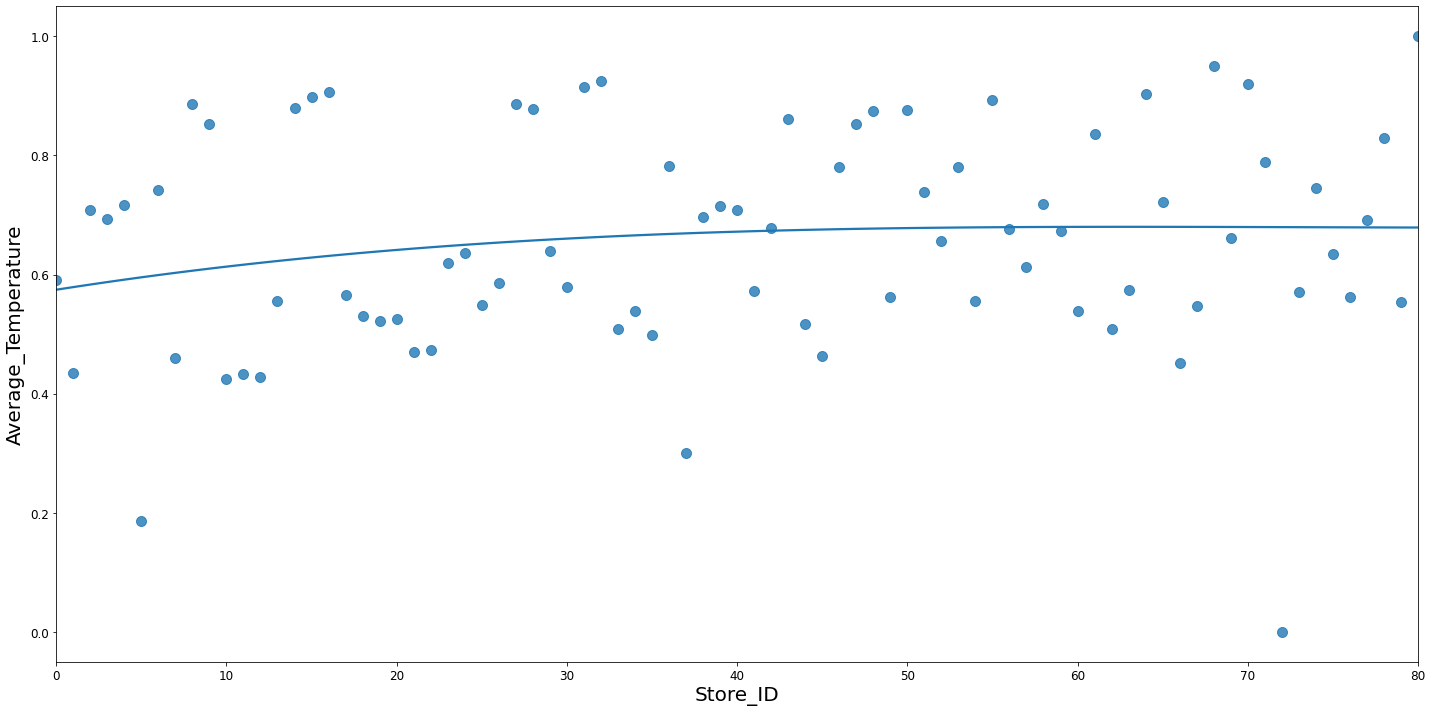

In [116]:
import seaborn as sns; 

plt.figure(figsize=(20,10))
ax = sns.regplot(x=dsTmp.index, y=dsTmp.average_temperature_mean, data=dsTmp, scatter_kws={"s": 100}, order=3, ci=None)
plt.ylabel('Average_Temperature', size = 20)
plt.xlabel('Store_ID', size = 20)
save_fig("temperature")
plt.show()

#### 2. Windspeed

Saving figure windspeed


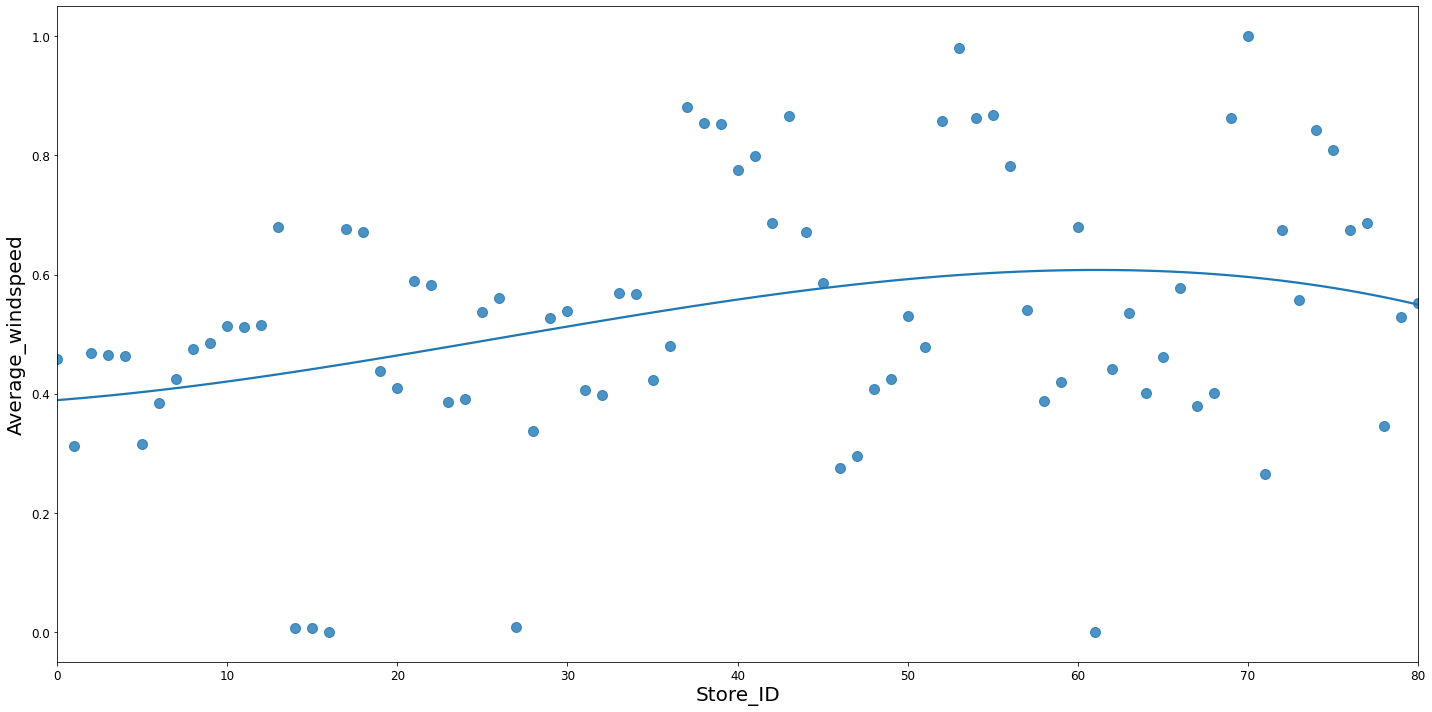

In [117]:
plt.figure(figsize=(20,10))
ax = sns.regplot(x=dsTmp.index, y=dsTmp.average_windspeed_mean, data=dsTmp, scatter_kws={"s": 100}, order=3, ci=None)
plt.ylabel('Average_windspeed', size = 20)
plt.xlabel('Store_ID', size = 20)
save_fig("windspeed")
plt.show()

#### 3. Dew point

Dew Point is a function of humidity and temperature therefore it displays similar relation to dispensed liters.

Saving figure dewpoint


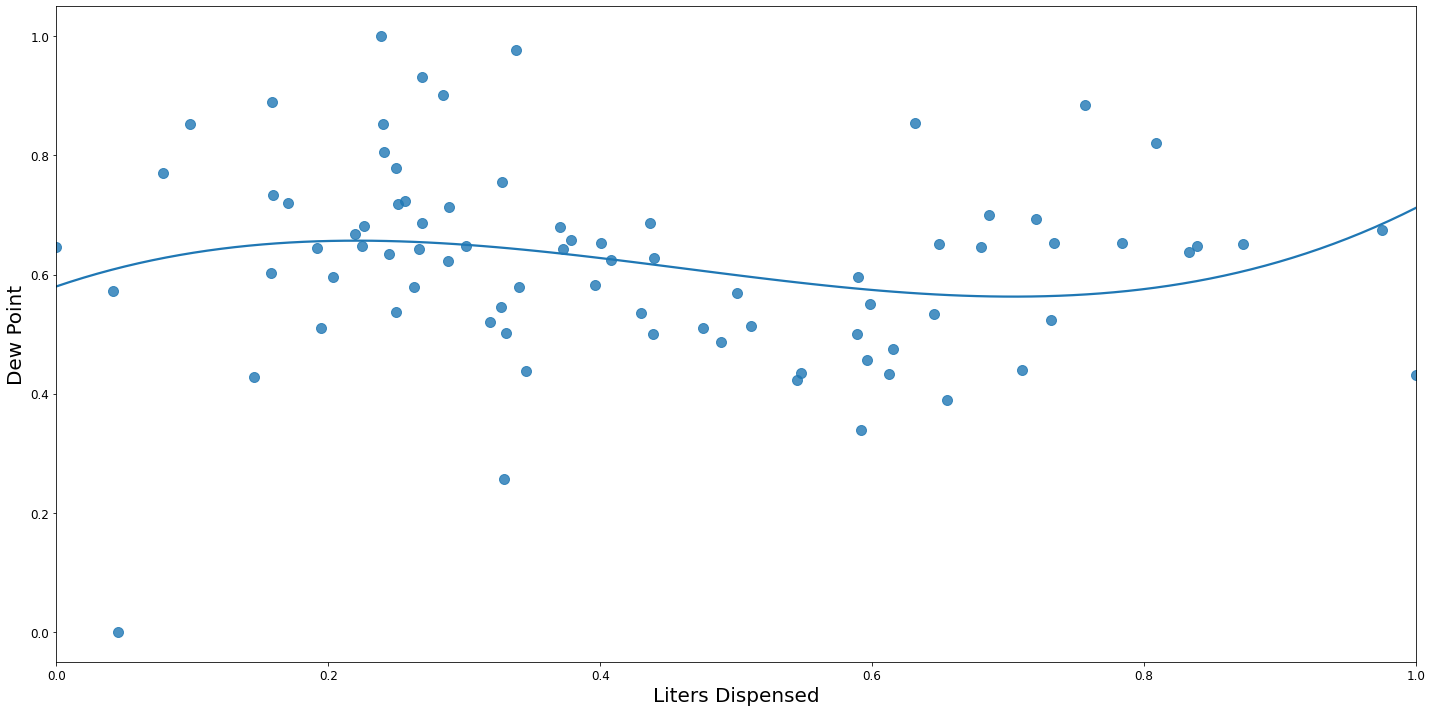

In [118]:
plt.figure(figsize=(20,10))
ax = sns.regplot(x=dsTmp.liters_dispensed_sum, y=dsTmp.dew_point_mean, data=dsTmp, scatter_kws={"s": 100}, order=3, ci=None)
plt.ylabel('Dew Point', size = 20)
plt.xlabel('Liters Dispensed', size = 20)
save_fig("dewpoint")
plt.show()

# Pipeline

A best practice when working with transformers or imputer is to the define Pipelines of transformations.

In our case we distinguish three main pipelines that work on different columns: 

* **cat_pipeline** - used for transform dates into ordinal attributes

* **num_pipeline** - used to fix the NaN values for numerical attributes 

* **one_hot_pipeline** - used for split phenomena into several colunmns, one for each value, cointaining 1 if the attribute is equal to one value, 0 otherwise



In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_attribs= ['date']
one_hot_attribs=['phenomena']
num_attribs= [ 'average_priceperliter', 
                'average_temperature','maximum_temperature','minimum_temperature','minimum_umidity','maximum_umidity','maximum_windspeed', 'average_windspeed', 
                'dew_point',
               'average_windspeed',
                'average_umidity', 
                'medium_visibility','working_day','sea_city','number_of_inhabitants'] #numerical attribute

cat_pipeline = Pipeline([ #date
    ('encoder',OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('nan_fixer', SimpleImputer(missing_values=np.nan,strategy='mean'))
   
])

one_hot_pipeline= Pipeline([ #phenomena
    ('one_hot_encoder', OneHotEncoder())
])

full_pipeline = ColumnTransformer([ 
    ("num", num_pipeline, num_attribs), 
    ("cat", cat_pipeline, cat_attribs),
    ("cat2", one_hot_pipeline, one_hot_attribs)
    
])

In [120]:
#call pipeline
ds_prepared = full_pipeline.fit_transform(ds)

label_prepared = ds.loc[:,['liters_dispensed']].values
ds.values

len(ds_prepared[0])

20

In [121]:
ds_prepared = np.c_[ds.values[:,0],ds_prepared]

### Creating Weather Clusters

The weather information has a lot of variables which might not all be useful. We will attempt to create weather clusters to see if we can define a unique attribute that represent temperature, umidity, windspeed etc.

In [122]:
#from numpy to dataframe
phenomena=['F0','F1','F2','F3']
attribs=num_attribs+cat_attribs+phenomena
newDs = pd.DataFrame(data=ds_prepared,columns=['store_id']+attribs)

In [123]:
scaler = MinMaxScaler()

weather_scaled = scaler.fit_transform(newDs[['average_temperature','average_umidity','average_windspeed','dew_point','maximum_temperature','minimum_temperature','maximum_umidity','minimum_umidity','maximum_windspeed']+phenomena])

weather_scaled

array([[0.31707317, 0.83823529, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.31707317, 0.88235294, 0.27777778, ..., 1.        , 0.        ,
        0.        ],
       [0.31707317, 0.76470588, 0.66666667, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.31707317, 0.39705882, 0.88888889, ..., 0.        , 0.        ,
        0.        ],
       [0.31707317, 0.70588235, 0.55555556, ..., 1.        , 0.        ,
        0.        ],
       [0.36585366, 0.83823529, 0.33333333, ..., 1.        , 0.        ,
        0.        ]])

To determine the best number of clusters we chosed to use the elbow curve.

The method consists of plotting the variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. 

Using the "elbow" as a cutoff point is a common heuristic in mathematical optimization to choose a point where diminishing returns are no longer worth the additional cost. 

In our case, adding another cluster beyond that specified by the elbow would not offer better data modeling.

In [124]:
"""from sklearn.cluster import KMeans

Nc = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()"""

"from sklearn.cluster import KMeans\n\nNc = range(1, 15)\nkmeans = [KMeans(n_clusters=i) for i in Nc]\n\nscore = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]\n\nplt.plot(Nc,score)\nplt.xlabel('Number of Clusters')\nplt.ylabel('Score')\nplt.title('Elbow Curve')\nplt.show()"

As we can see from the figure above the best number of clusters is 4.

In [125]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=2400, algorithm = 'auto')
kmeans.fit(weather_scaled)
newDs['weather_cluster'] = kmeans.labels_

newDs= newDs.drop(columns=['average_temperature','medium_visibility','average_umidity','average_windspeed','dew_point','maximum_temperature','minimum_temperature','maximum_umidity','minimum_umidity','maximum_windspeed']+phenomena)
newDs

,store_id,average_priceperliter,working_day,sea_city,number_of_inhabitants,date,weather_cluster
0,165,1.44426,0,0,13464,13,0
1,165,1.44731,1,0,13464,14,1
2,165,1.44737,1,0,13464,15,1
3,165,1.44961,1,0,13464,18,0
4,165,1.44534,0,0,13464,19,1
...,...,...,...,...,...,...,...
35684,150,1.44564,1,1,25520,370,0
35685,150,1.46138,1,1,25520,373,1
35686,150,1.46741,0,1,25520,374,0
35687,150,1.46374,0,1,25520,375,1


Last but not least, we need to scale our dataset. 

In [126]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline


num_attribs= [ 'store_id','average_priceperliter','working_day','sea_city','date','weather_cluster','number_of_inhabitants']


scaler_pipeline = Pipeline([
    ('scaler',MinMaxScaler())
   
])

full_pipeline = ColumnTransformer([ 
    ("num", scaler_pipeline, num_attribs),  
])

In [127]:
#call pipeline
ds_prepared = full_pipeline.fit_transform(newDs)

ds_prepared

array([[0.91954023, 0.36582972, 0.        , ..., 0.01793103, 0.        ,
        0.02763946],
       [0.91954023, 0.37641457, 1.        , ..., 0.01931034, 0.33333333,
        0.02763946],
       [0.91954023, 0.37664329, 1.        , ..., 0.02068966, 0.33333333,
        0.02763946],
       ...,
       [0.83333333, 0.44634225, 0.        , ..., 0.51586207, 0.        ,
        0.05574516],
       [0.83333333, 0.43356495, 0.        , ..., 0.51724138, 0.33333333,
        0.05574516],
       [0.83333333, 0.39673813, 1.        , ..., 0.51862069, 0.33333333,
        0.05574516]])

## Training and Models Comparison

In this section we are going to train several models and compare their scores with several metrics. 

In [128]:
from sklearn.model_selection import train_test_split

train_setX, test_setX, train_setY,test_setY= train_test_split(ds_prepared,label_prepared, test_size=0.2, random_state=42)


In [129]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import*
from sklearn.model_selection import GridSearchCV
import pickle
import time


maxLiterValue=ds.liters_dispensed.max()
minLiterValue=ds.liters_dispensed.min()


def compute_performance(classifiers,names,X,y):
    score_dict = {}
    score_dict['Classifier'] = {}
    score_dict['rmse'] = {}
    score_dict['variance']= {}
    score_dict['mae']= {}
    score_dict['median_se']= {}
    score_dict['r2']= {}
    
 

    for i in range(len(classifiers)):
        value_predictions = classifiers[i].predict(X)
        rmse = (np.sqrt(mean_squared_error(y,value_predictions))-minLiterValue)/(maxLiterValue-minLiterValue)
        variance = explained_variance_score(y,value_predictions)
        mae = mean_absolute_error(y,value_predictions)
        median_se = median_absolute_error(y, value_predictions)
        r2 = r2_score(y, value_predictions)
       
        name = names[i]

        score_dict['Classifier'][i] = name
        score_dict['rmse'][i] = rmse
        score_dict['variance'][i] = variance
        score_dict['mae'][i] = mae
        score_dict['median_se'][i] = median_se
        score_dict['r2'][i] = r2
       
        
    return score_dict

In [130]:
regressors = []
names = []

load_from_disk=True
train_setY=train_setY.reshape(-1)

## Linear Regressor

In [131]:
from sklearn.linear_model import LinearRegression

if(not load_from_disk):
    
    lin_reg = LinearRegression()
    lin_reg = lin_reg.fit(train_setX, train_setY)

    #save the model to disk
    filename = './Models/lin_reg.sav'
    pickle.dump(lin_reg, open(filename, 'wb'))

else: 
    filename = './Models/lin_reg.sav'
    lin_reg = pickle.load(open(filename, 'rb'))

    
regressors.append(lin_reg)
names.append("Linear Regressor")
#linear_models.append("Linear Regressor")

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


## Huber Regressor

In [132]:
from sklearn.linear_model import HuberRegressor

if(not load_from_disk):
    
    huber_reg = HuberRegressor()
    huber_reg.fit(train_setX, train_setY)
    
    # save the model to disk
    filename = './Models/huber_reg.sav'
    pickle.dump(huber_reg, open(filename, 'wb'))
    
else:
    
    # load the model from disk
    filename = './Models/huber_reg.sav'
    huber_reg = pickle.load(open(filename, 'rb'))
    
    


regressors.append(huber_reg)
names.append("Huber Regressor")
#linear_models.append("Huber Regressor")

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)


## SGD Regressor

In [133]:
from sklearn.linear_model import SGDRegressor

if(not load_from_disk):
    
    sgd_reg = SGDRegressor(random_state=42)
    sgd_reg.fit(train_setX, train_setY)
    
    # save the model to disk
    filename = './Models/sgd_reg.sav'
    pickle.dump(sgd_reg, open(filename, 'wb'))
    
else:
    
    # load the model from disk
    filename = './Models/sgd_reg.sav'
    sgd_reg = pickle.load(open(filename, 'rb'))
    
    
regressors.append(sgd_reg)
names.append("SGD Regressor")
#linear_models.append("SGD Regressor")

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


## Bayesian Ridge Regressor


In [134]:
from sklearn.linear_model import BayesianRidge

if(not load_from_disk):

    bay_reg = BayesianRidge()
    bay_reg.fit(train_setX, train_setY)

    # save the model to disk
    filename = './Models/bay_reg.sav'
    pickle.dump(bay_reg, open(filename, 'wb'))

else:
    #load the model from disk
    filename = './Models/bay_reg.sav'
    bay_reg = pickle.load(open(filename, 'rb'))
    
    
regressors.append(bay_reg)
names.append("Bayesian Ridge Regressor")
#linear_models.append("Bayesian Ridge Regressor")

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


## DecisionTreeRegressor

In [135]:
from sklearn.tree import DecisionTreeRegressor

if(not load_from_disk):
    tree_reg = DecisionTreeRegressor(random_state=42)
    tree_reg.fit(train_setX, train_setY)
    
    # save the model to disk
    filename = './Models/tree_reg.sav'
    pickle.dump(tree_reg, open(filename, 'wb'))

else:
    # load the model from disk
    filename = './Models/tree_reg.sav'
    tree_reg = pickle.load(open(filename, 'rb'))
   
    
regressors.append(tree_reg)
names.append("Tree Regressor")
#tree_models.append("Tree Regressor")

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')


In [136]:
# Grid approach
if(not load_from_disk):
    tree_params_grid = {'criterion': ['mse', 'friedman_mse', 'mae'],'splitter': ['best', 'random']} 

    tree_grid_search = GridSearchCV(tree_reg, tree_params_grid, cv=5,
                                scoring='neg_mean_squared_error', return_train_score=True)

    tree_grid_search.fit(train_setX, train_setY)
    best_tree_params = tree_grid_search.best_estimator_


    # save the model to disk
    filename = './Models/tree_grid_search.sav'
    pickle.dump(tree_grid_search, open(filename, 'wb'))

else:
    # load the model from disk
    filename = './Models/tree_grid_search.sav'
    tree_grid_search = pickle.load(open(filename, 'rb'))
    #print(tree_grid_search)
    


regressors.append(tree_grid_search)
names.append("Tree Regressor Grid")
#tree_models.append("Tree Regressor Grid")

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'splitter': ['best', 'random']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,

## KNeighborsRegressor

In [137]:
from sklearn.neighbors import KNeighborsRegressor

if(not load_from_disk):
    kn_reg = KNeighborsRegressor()
    kn_reg.fit(train_setX, train_setY)

    # save the model to disk
    filename = './Models/kn_reg.sav'
    pickle.dump(kn_reg, open(filename, 'wb'))

else:
    # load the model from disk
    filename = './Models/kn_reg.sav'
    kn_reg = pickle.load(open(filename, 'rb'))
   
    


regressors.append(kn_reg)
names.append("K Neighbor Regressor")
#instance_based.append("K Neighbor Regressor")

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


In [138]:
#KNeighborsGrid
if(not load_from_disk):
    kn_params_grid = {'n_neighbors': [5,10,15,20,50],'weights': ['uniform','distance'],'leaf_size': [20,30,50]} 

    kn_grid_search = GridSearchCV(kn_reg, kn_params_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
    kn_grid_search.fit(train_setX, train_setY)
    best_kn_params = kn_grid_search.best_estimator_


    # save the model to disk
    filename = './Models/kn_grid_search.sav'
    pickle.dump(kn_reg, open(filename, 'wb'))

else:
    # load the model from disk
    filename = './Models/kn_grid_search.sav'
    kn_grid_search = pickle.load(open(filename, 'rb'))
    
    


regressors.append(kn_grid_search)
names.append("K Neighbor Regressor Grid")
#instance_based.append("K Neighbor Regressor Grid")

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


## Random Forest Regressor

In [139]:
from sklearn.ensemble import RandomForestRegressor

if(not load_from_disk):
    forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
    forest_reg.fit(train_setX, train_setY)

    # save the model to disk
    filename = './Models/forest_reg.sav'
    pickle.dump(forest_reg, open(filename, 'wb'))

else:
    # load the model from disk
    filename = './Models/forest_reg.sav'
    forest_reg = pickle.load(open(filename, 'rb'))
    #print(forest_reg)


regressors.append(forest_reg)
names.append("Forest Regressor")
#ensemble_models.append("Forest Regressor")

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [140]:
#Random Forest Grid
if(not load_from_disk): 
    forest_param_grid = [
         {'n_estimators': [3, 10, 30,100], 'max_features': [2, 4, 6]},
         {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
       ]

    forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, cv=5,
                                scoring='neg_mean_squared_error', return_train_score=True)
    forest_grid_search.fit(train_setX,train_setY)
    best_forest_params = forest_grid_search.best_estimator_
    filename = './Models/forest_grid_search.sav'
    pickle.dump(forest_grid_search, open(filename, 'wb'))
    
else: 
    # load the model from disk
    filename = './Models/forest_grid_search.sav'
    forest_grid_search = pickle.load(open(filename, 'rb'))
   
regressors.append(forest_grid_search)
names.append("Forest Regressor Grid")
    



## Bagging Regressor

In [141]:
from sklearn.ensemble import BaggingRegressor

if(not load_from_disk):
    bagging_reg = BaggingRegressor(random_state=42)
    bagging_reg.fit(train_setX, train_setY)


    #save the model to disk
    filename = './Models/bagging_reg.sav'
    pickle.dump(bagging_reg, open(filename, 'wb'))
else: 
    #load the model from disk
    filename = './Models/bagging_reg.sav'
    bagging_reg = pickle.load(open(filename, 'rb'))
    
names.append("Bagging Regressor")


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=42, verbose=0,
                 warm_start=False)


## Support Vector Machine Regressor


In [142]:
from sklearn.svm import SVR

if( not load_from_disk ): 
    svr_reg = SVR()
    svr_reg.fit(train_setX, train_setY)

    # save the model to disk
    filename = './Models/svr_reg.sav'
    pickle.dump(svr_reg, open(filename, 'wb'))
else:
    # load the model from disk
    filename = './Models/svr_reg.sav'
    svr_reg = pickle.load(open(filename, 'rb'))
    
regressors.append(svr_reg)
names.append("SVR Regressor")

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [143]:
score_dict_train = compute_performance(regressors, names, test_setX, test_setY)
score_df_train = pd.DataFrame(score_dict_train)
score_df_train

,Classifier,rmse,variance,mae,median_se,r2
0,Linear Regressor,0.198842,0.039054,1258.576481,1097.767101,0.039018
1,Huber Regressor,0.202153,0.031096,1224.194094,983.150772,0.006885
2,SGD Regressor,0.198849,0.038958,1257.246746,1093.828330,0.038957
3,Bayesian Ridge Regressor,0.198845,0.039024,1258.660446,1097.105311,0.038988
4,Tree Regressor,0.097193,0.768558,543.818680,379.915000,0.768478
5,Tree Regressor Grid,0.097377,0.767736,545.311999,383.250000,0.767606
6,K Neighbor Regressor,0.124279,0.622798,687.677024,455.936000,0.622797
7,K Neighbor Regressor Grid,0.124279,0.622798,687.677024,455.936000,0.622797
8,Forest Regressor,0.078963,0.846633,446.145007,316.999000,0.846607
9,Forest Regressor Grid,0.076052,0.857630,431.007807,308.728500,0.857601


Saving figure MSE error TRAIN


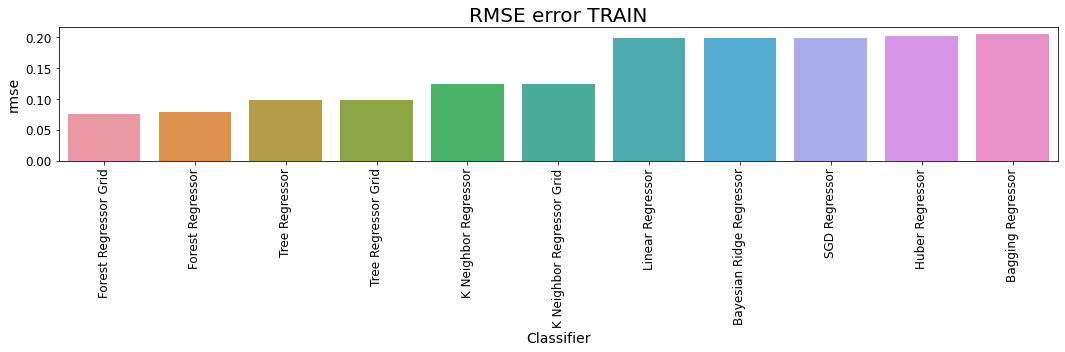

In [144]:
plt.figure(figsize=(15,5))
a = score_df_train.sort_values(by = 'rmse')
p = sns.barplot(x = a.Classifier, y = a.rmse)
p = plt.xticks(rotation=90)
plt.title("RMSE error TRAIN", size=20)
#save_fig("MSE error TRAIN")

Saving figure MAE error TRAIN


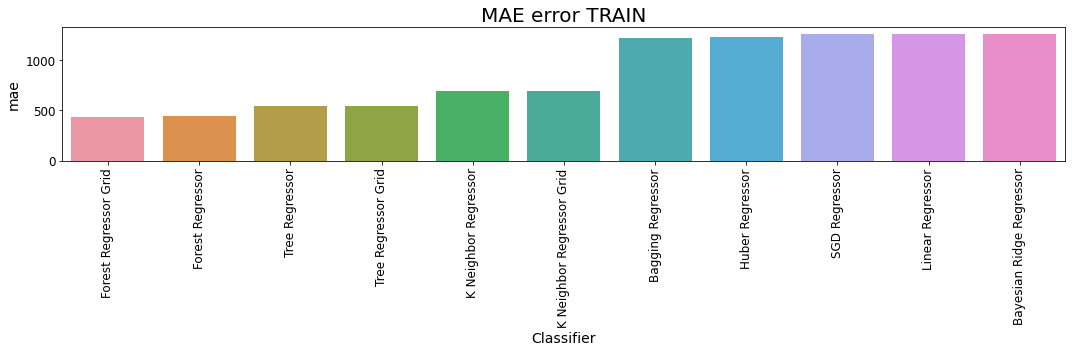

In [145]:
plt.figure(figsize=(15,5))
a = score_df_train.sort_values(by = 'mae')
p = sns.barplot(x = a.Classifier, y = a.mae)
p = plt.xticks(rotation=90)
plt.title("MAE error TRAIN", size=20)
#save_fig("MAE error TRAIN")

Saving figure R2 error TEST


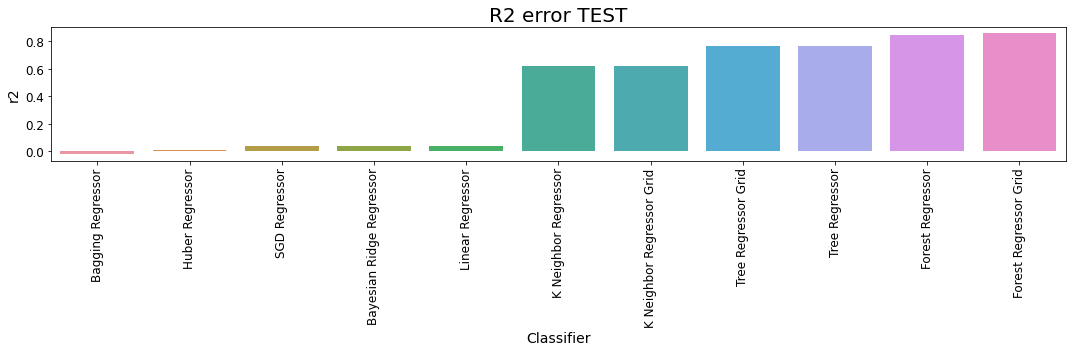

In [146]:
plt.figure(figsize=(15,5))
a = score_df_train.sort_values(by = 'r2', ascending = True)
p = sns.barplot(x = a.Classifier, y = a.r2)
p = plt.xticks(rotation=90)
plt.title("R2 error TEST", size=20)
save_fig("R2 error TEST")

**Since Forest Regression performs better than the other regressor we decide to plot a graph that shows the differences between the actual and predicted values.**

Saving figure forest_1


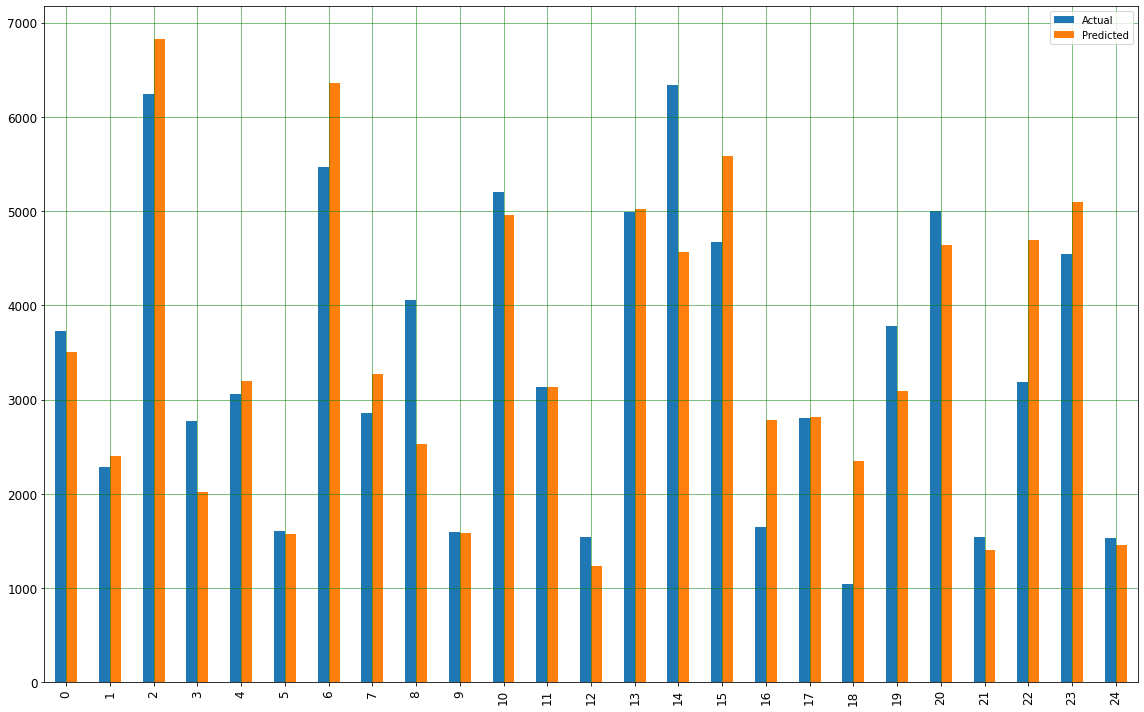

In [147]:
test_setY= test_setY.reshape(-1)

 

df = pd.DataFrame({'Actual': test_setY, 'Predicted': forest_reg.predict(test_setX)})

 

df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#save_fig("forest_1")
plt.show()

Saving figure forest_1


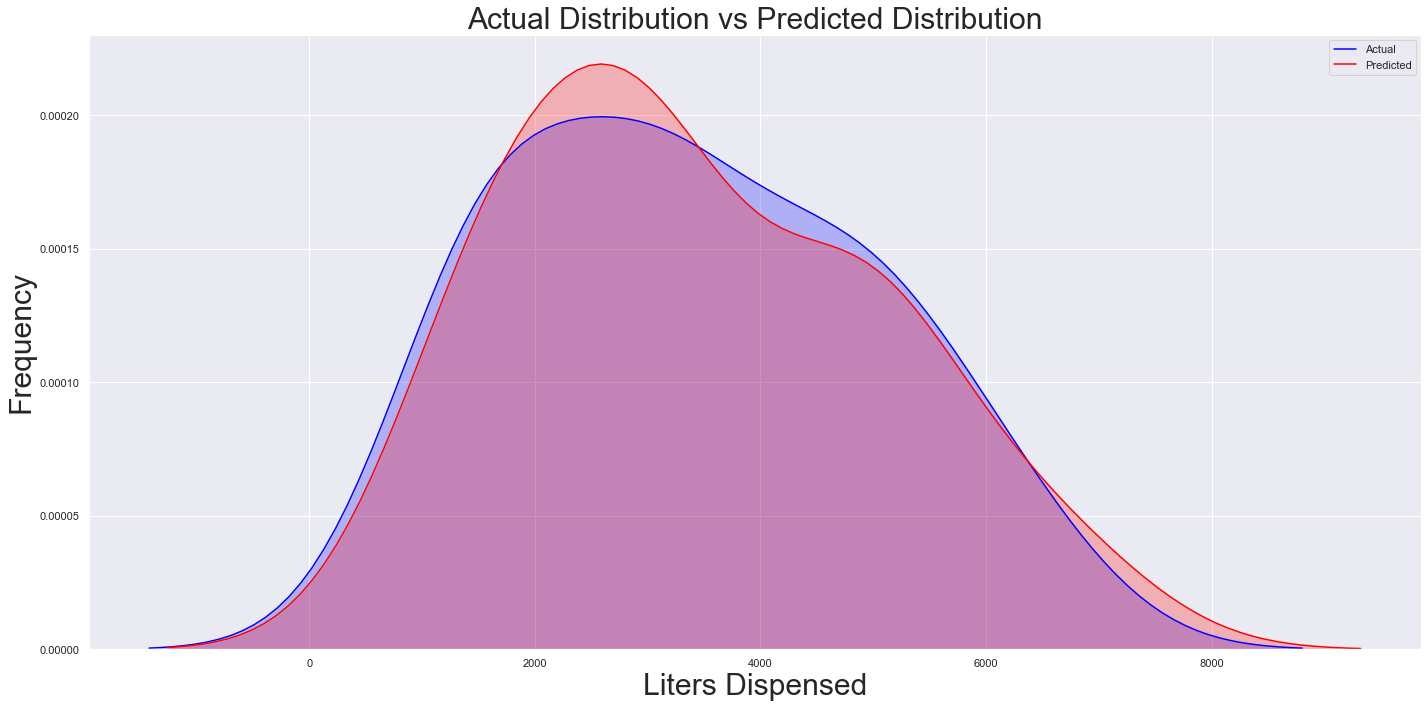

In [148]:
import seaborn as sns, numpy as np 


plt.figure(figsize=(20,10))

sns.set();
ax = sns.kdeplot(df1.Actual, shade=True,color='blue')
ax = sns.kdeplot(df1.Predicted, shade=True,color='red')

plt.ylabel('Frequency', size = 30)
plt.xlabel('Liters Dispensed', size = 30)
plt.title("Actual Distribution vs Predicted Distribution", size=30)
#save_fig("forest_1")
plt.show()


## Neural Networks attempt: Long Short Term Memory Network

In this section we try to use a recurrent neural network called Long Short Term Memory.


In [216]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
    return agg


In [217]:
reframed = series_to_supervised(label_prepared, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,3177.37,3782.55,4033.06,3882.64,4031.18,4095.96,3887.53,4631.45
8,3782.55,4033.06,3882.64,4031.18,4095.96,3887.53,4631.45,4296.23
9,4033.06,3882.64,4031.18,4095.96,3887.53,4631.45,4296.23,4595.89


In [218]:
reframed = reframed.values
reframed = reframed.astype('float32')

scaler_features = MinMaxScaler(feature_range=(0, 1))

reframed = scaler_features.fit_transform(reframed)

In [219]:
# split into train and test sets
train = reframed[:(len(reframed)-7000), :]
test = reframed[(len(reframed)-7000):len(reframed), :]

In [220]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [221]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28682, 1, 7) (28682,) (7000, 1, 7) (7000,)


In [222]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Dropout
from keras.layers import LSTM


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    



Epoch 1/50
399/399 - 1s - loss: 0.0982 - val_loss: 0.0591
Epoch 2/50
399/399 - 1s - loss: 0.0796 - val_loss: 0.0588
Epoch 3/50
399/399 - 1s - loss: 0.0790 - val_loss: 0.0582
Epoch 4/50
399/399 - 1s - loss: 0.0788 - val_loss: 0.0584
Epoch 5/50
399/399 - 1s - loss: 0.0786 - val_loss: 0.0588
Epoch 6/50
399/399 - 1s - loss: 0.0786 - val_loss: 0.0591
Epoch 7/50
399/399 - 1s - loss: 0.0785 - val_loss: 0.0599
Epoch 8/50
399/399 - 1s - loss: 0.0785 - val_loss: 0.0597
Epoch 9/50
399/399 - 1s - loss: 0.0785 - val_loss: 0.0598
Epoch 10/50
399/399 - 1s - loss: 0.0784 - val_loss: 0.0595
Epoch 11/50
399/399 - 1s - loss: 0.0784 - val_loss: 0.0596
Epoch 12/50
399/399 - 1s - loss: 0.0784 - val_loss: 0.0595
Epoch 13/50
399/399 - 1s - loss: 0.0783 - val_loss: 0.0596
Epoch 14/50
399/399 - 1s - loss: 0.0783 - val_loss: 0.0597
Epoch 15/50
399/399 - 1s - loss: 0.0783 - val_loss: 0.0593
Epoch 16/50
399/399 - 1s - loss: 0.0782 - val_loss: 0.0596
Epoch 17/50
399/399 - 1s - loss: 0.0782 - val_loss: 0.0594
Epoch 

In [223]:
# make a prediction
yhat = model.predict(test_X)

In [224]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [225]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler_features.inverse_transform(inv_yhat)

In [226]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler_features.inverse_transform(inv_y)

In [227]:
act = [i[0] for i in inv_y] # last element is the predicted
pred = [i[0] for i in inv_yhat] # last element is the actual 

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 647.672


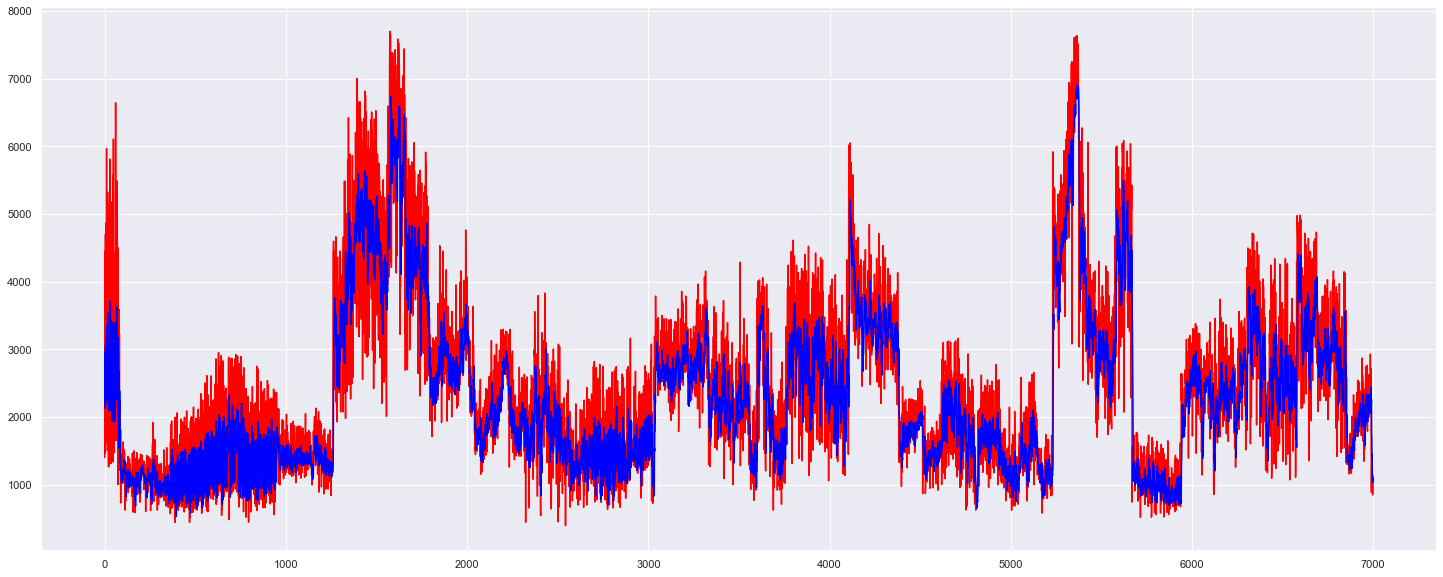

In [228]:
predicted_lstm = pd.DataFrame({'predicted':pred,'liters_dispensed':act})
predicted_lstm['liters_dispensed'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')

plt.show()


Saving figure LSTM


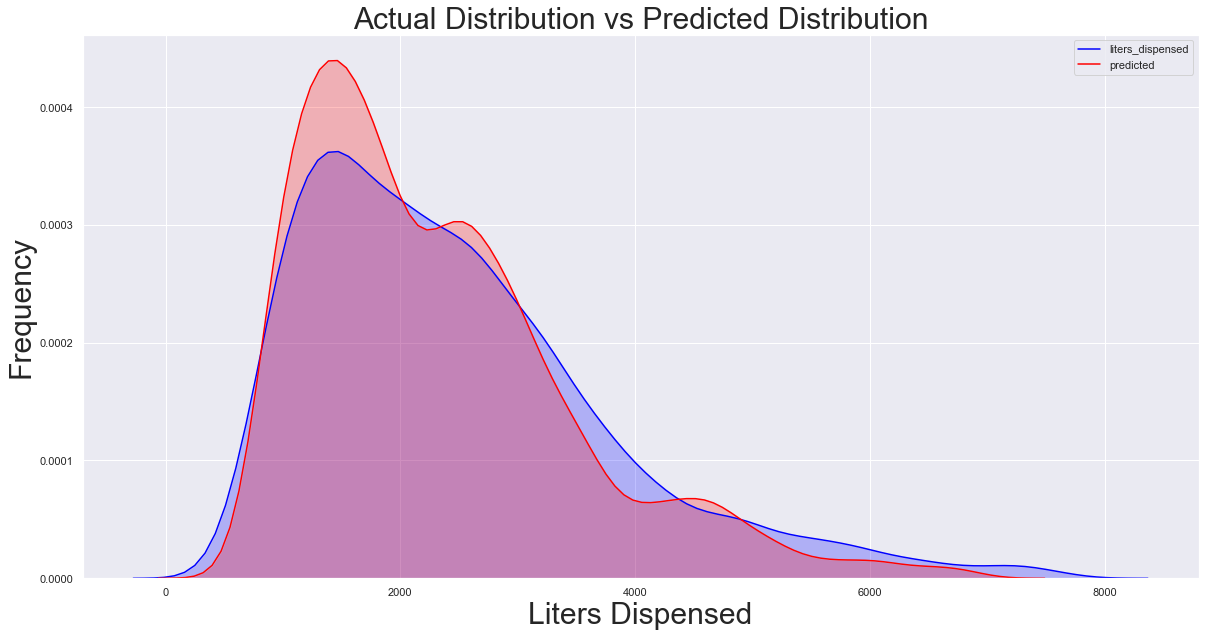

In [229]:
import seaborn as sns, numpy as np 


plt.figure(figsize=(20,10))

sns.set();
ax = sns.kdeplot(predicted_lstm['liters_dispensed'], shade=True,color='blue')
ax = sns.kdeplot(predicted_lstm['predicted'], shade=True,color='red')

plt.ylabel('Frequency', size = 30)
plt.xlabel('Liters Dispensed', size = 30)
plt.title("Actual Distribution vs Predicted Distribution", size=30)

figure = ax.get_figure()
#save_figure(figure,"LSTM")
plt.show()